In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels.api as sm

from analyzer.metric import MetricCalculator
from analyzer.model.regression_model import RegressionModel
from data.io import Reader
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from keras.src.layers import Dense
from keras import Sequential, Input
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Постановка задачи
1. Провести анализ и предсказать возраст краба

датасет:
https://raw.githubusercontent.com/Semendyeav/datasets/main/PDA110_CrabAge.csv



# Проверка целостности датасета

In [132]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv("https://raw.githubusercontent.com/Semendyeav/datasets/main/PDA110_CrabAge.csv")
df = df_original.copy().reset_index(drop=True)
df.head(10)

,sex,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
0,I,0.7125,0.5375,0.1750,3.047571,1.445825,0.637864,0.765436,6
1,F,1.4250,1.1625,0.3875,27.456491,12.643877,7.399220,7.229122,9
2,F,1.3000,1.0250,0.4000,20.184844,8.065433,4.337473,6.378637,10
3,F,1.4250,1.1375,0.4125,30.036295,12.473780,6.222715,8.079607,14
4,I,1.0625,0.8250,0.2875,9.256112,3.727959,2.182911,2.919999,6
5,M,1.2750,0.9875,0.3125,16.456885,6.917278,3.784658,5.329706,11
6,F,1.3750,1.0625,0.3125,27.328918,15.521351,4.507570,6.095142,8
7,M,1.4625,1.2000,0.4625,29.483480,12.303683,7.512618,8.079607,10
8,I,1.0500,0.8000,0.2500,9.638830,4.946988,1.417475,2.679028,8
9,I,1.2500,0.9500,0.2750,15.889895,7.937860,3.005047,4.252425,9


In [133]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             3893 non-null   object 
 1   length          3893 non-null   float64
 2   diameter        3893 non-null   float64
 3   height          3893 non-null   float64
 4   weight          3893 non-null   float64
 5   shucked_weight  3893 non-null   float64
 6   viscera_weight  3893 non-null   float64
 7   shell_weight    3893 non-null   float64
 8   age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


In [134]:
# посмотрим на пропуски в данных
df.isna().sum()

sex               0
length            0
diameter          0
height            0
weight            0
shucked_weight    0
viscera_weight    0
shell_weight      0
age               0
dtype: int64

In [135]:
# Посмотрим статистику о датасете
df.describe()

,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,1.311306,1.020893,0.349374,23.567275,10.207342,5.136546,6.795844,9.954791
std,0.300431,0.248233,0.104976,13.891201,6.275275,3.104133,3.943392,3.220967
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


# Оптимизируем датасет

In [136]:
df['age'] = df['age'].astype('uint8')

In [137]:
# проверяем
df.describe()

,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,1.311306,1.020893,0.349374,23.567275,10.207342,5.136546,6.795844,9.954791
std,0.300431,0.248233,0.104976,13.891201,6.275275,3.104133,3.943392,3.220967
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             3893 non-null   object 
 1   length          3893 non-null   float64
 2   diameter        3893 non-null   float64
 3   height          3893 non-null   float64
 4   weight          3893 non-null   float64
 5   shucked_weight  3893 non-null   float64
 6   viscera_weight  3893 non-null   float64
 7   shell_weight    3893 non-null   float64
 8   age             3893 non-null   uint8  
dtypes: float64(7), object(1), uint8(1)
memory usage: 247.2+ KB


# Проводим первичный визуальный анализ зависимостей данных

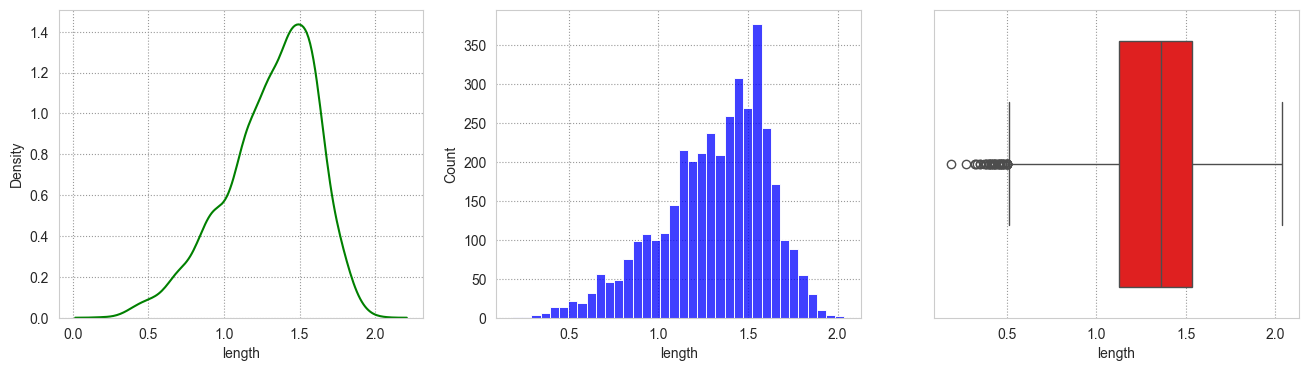

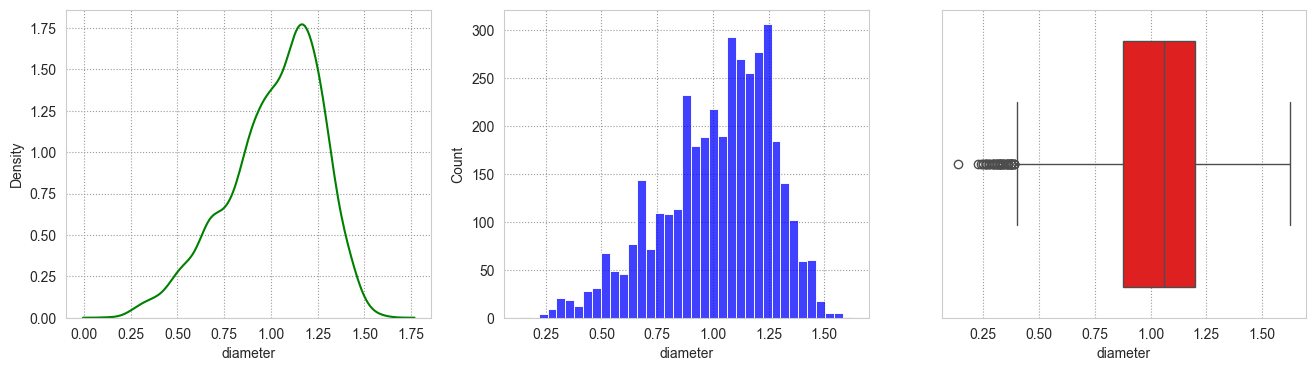

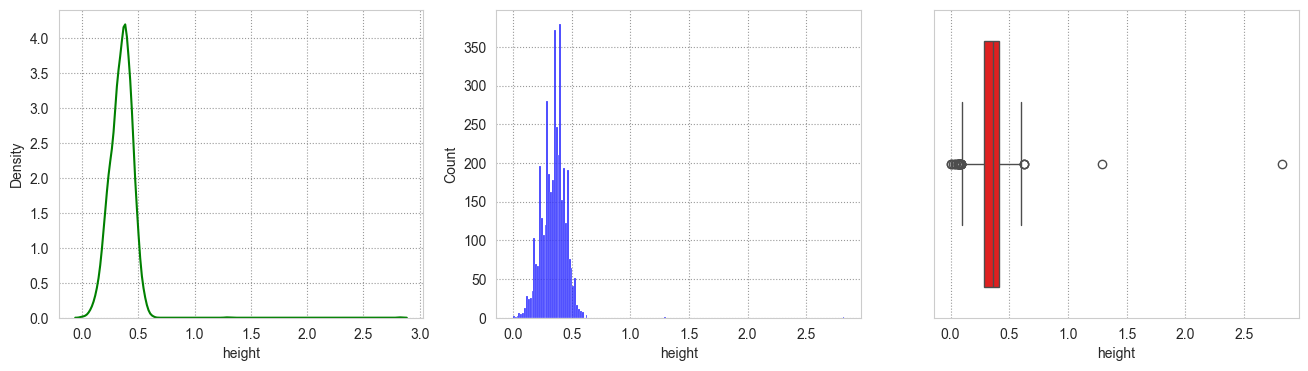

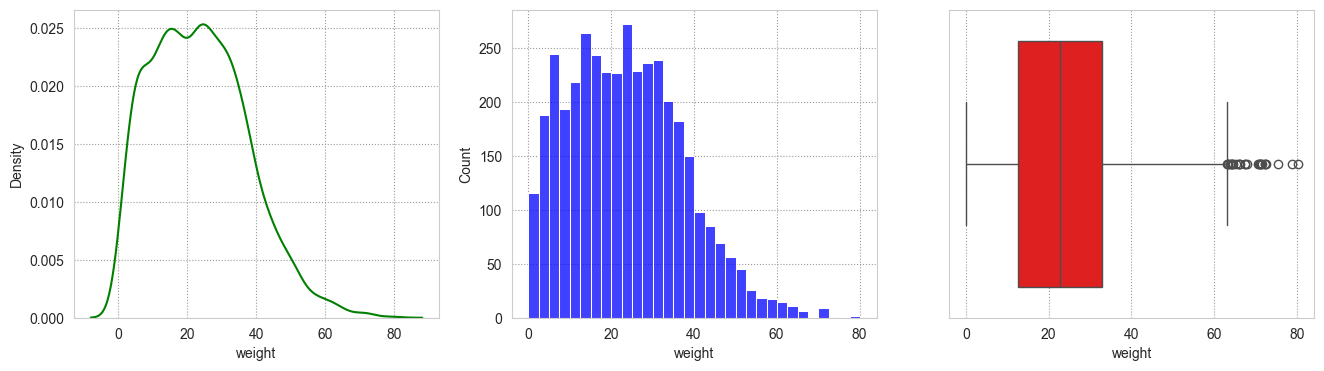

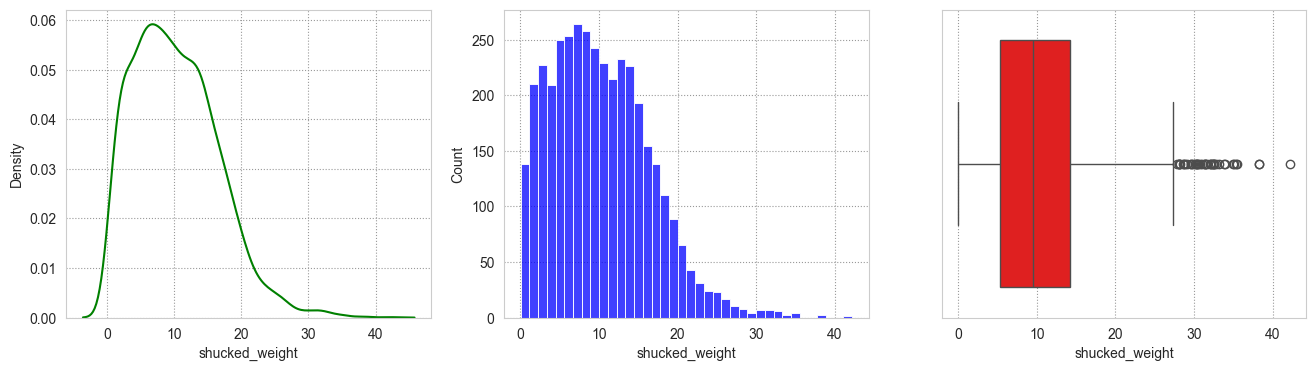

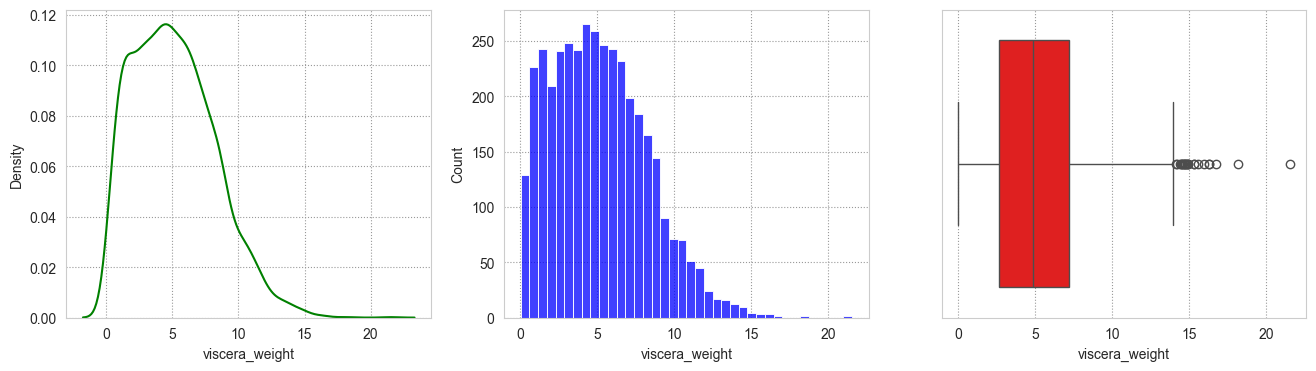

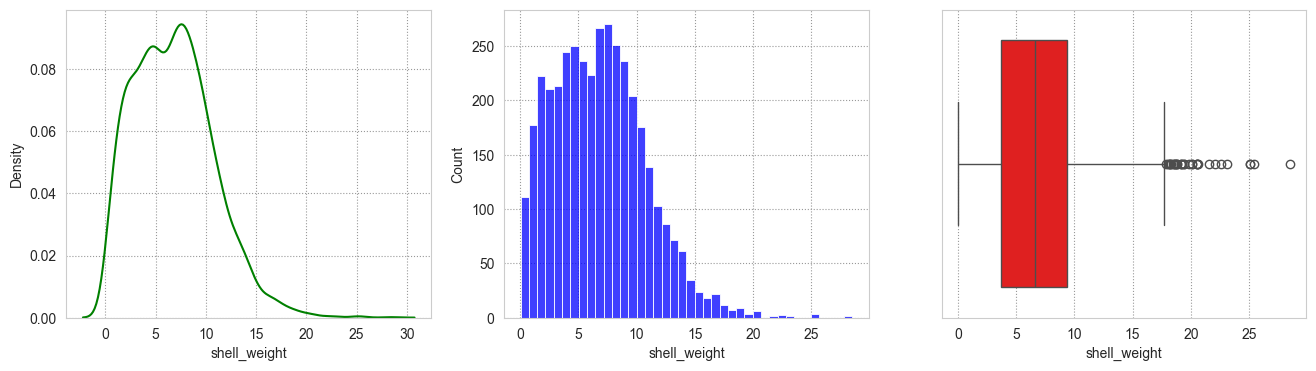

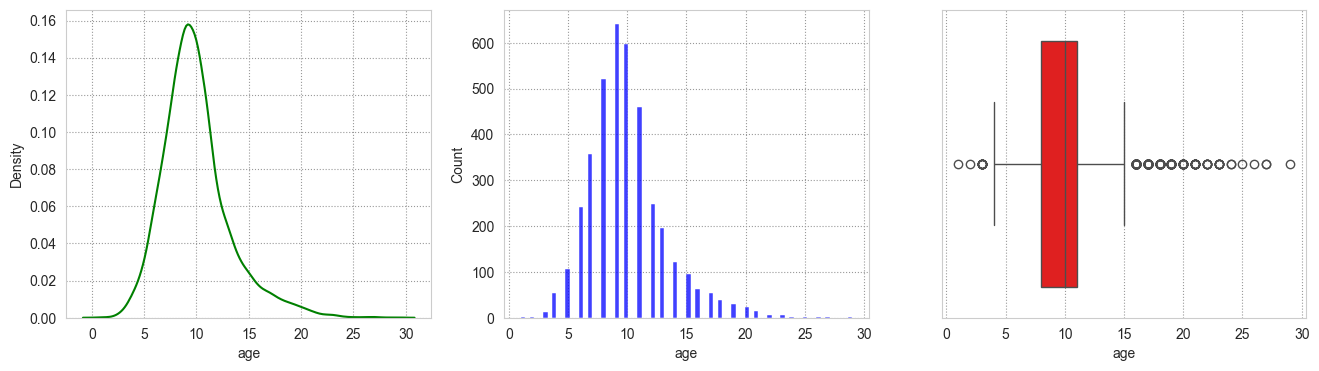

In [139]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

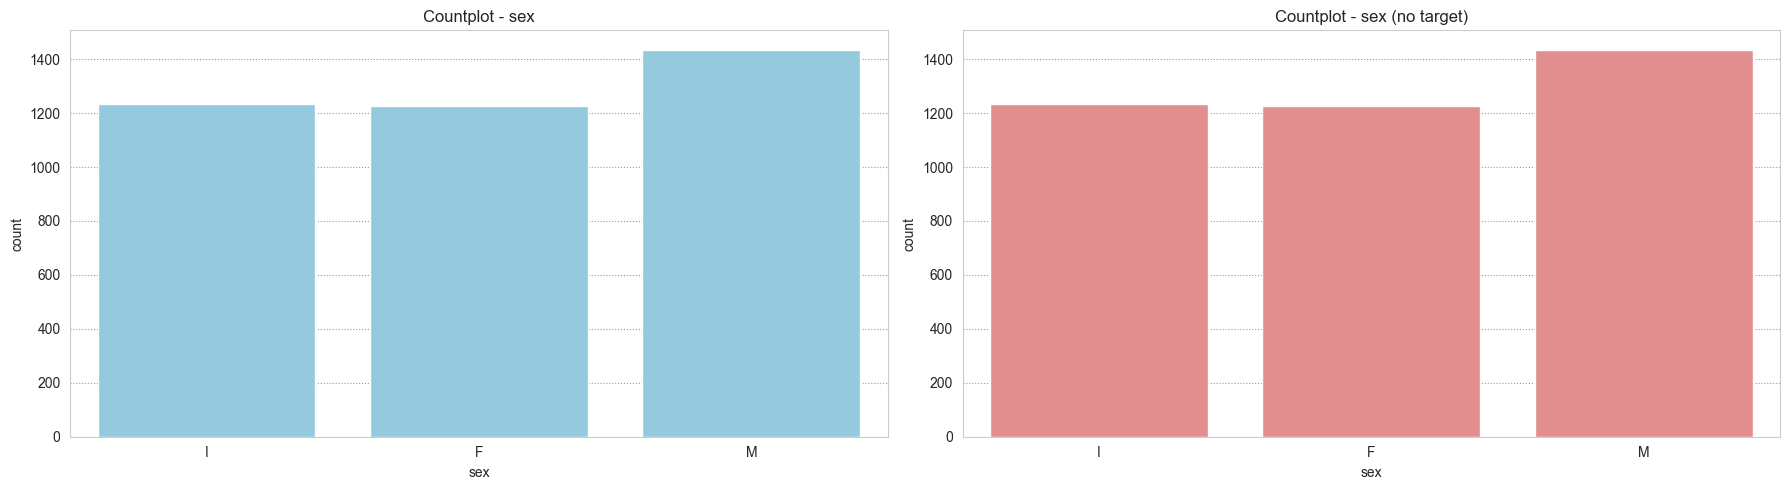

In [140]:
# Посмотрим на распределение категориальных величин
Drawer.plot_categorical_seaborn(df)

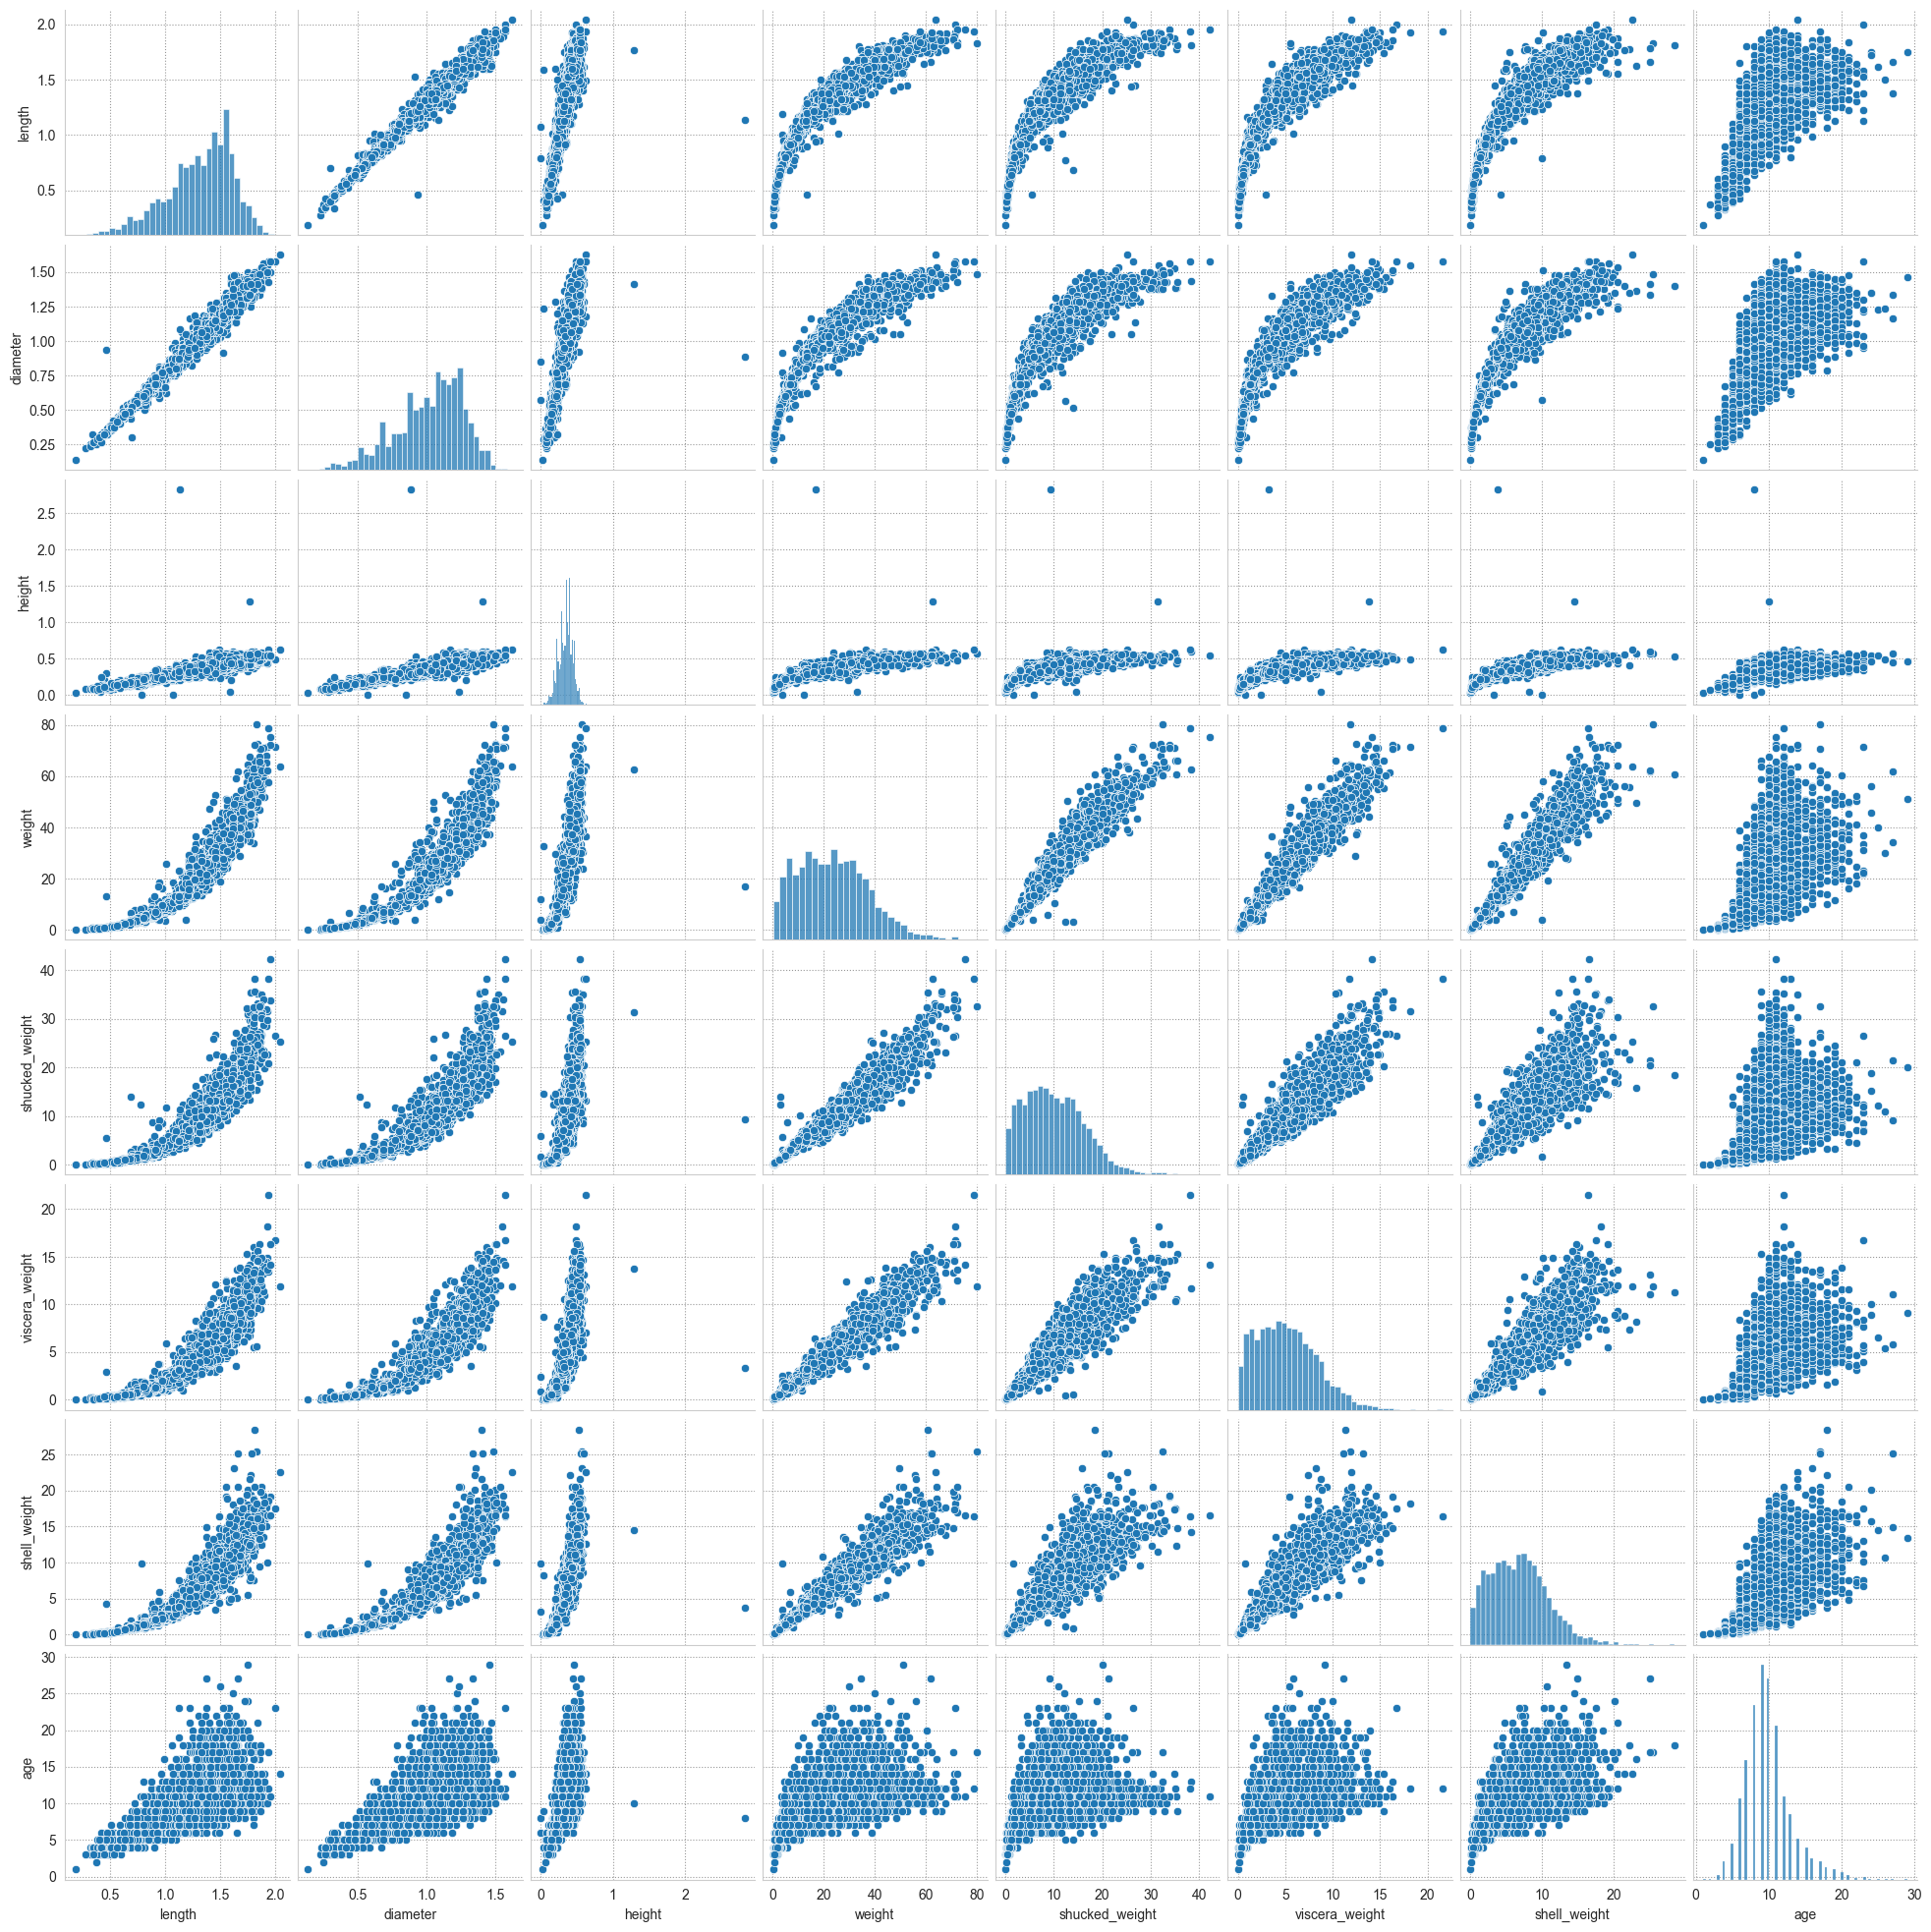

In [141]:
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

# Проводим оценку зависимостей

## стат.обработка непрерывных данных

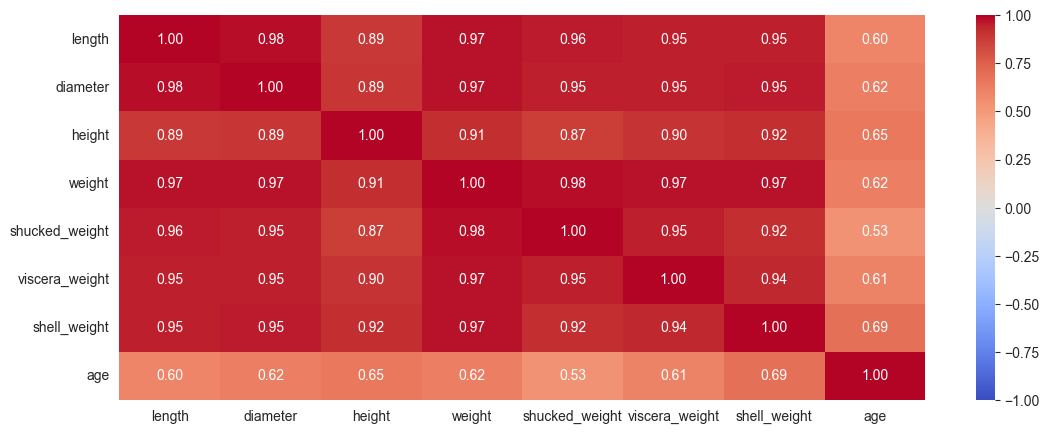

In [142]:
# Исследуем тепловую карту корреляции непрерывных признаков 
Drawer.plot_heatmap(df, method='spearman', boundary=0.5)

In [143]:
# проверяем распределения между таргетом и признаками
for column in df.select_dtypes(include='number').columns:
    print(f"\n{column} и age:")
    groups = [df[column], df['age']]
    StatCriteria().mannwhitneyu(groups)


length и age:
Mann-Whitney U test
U_statistic = 3263.500
Распределения двух выборок не равны (p-value = 0.000).

diameter и age:
Mann-Whitney U test
U_statistic = 2282.000
Распределения двух выборок не равны (p-value = 0.000).

height и age:
Mann-Whitney U test
U_statistic = 3.000
Распределения двух выборок не равны (p-value = 0.000).

weight и age:
Mann-Whitney U test
U_statistic = 12231347.000
Распределения двух выборок не равны (p-value = 0.000).

shucked_weight и age:
Mann-Whitney U test
U_statistic = 7381227.000
Распределения двух выборок не равны (p-value = 0.047).

viscera_weight и age:
Mann-Whitney U test
U_statistic = 2016158.000
Распределения двух выборок не равны (p-value = 0.000).

shell_weight и age:
Mann-Whitney U test
U_statistic = 3959715.000
Распределения двух выборок не равны (p-value = 0.000).

age и age:
Mann-Whitney U test
U_statistic = 7577724.500
Распределения двух выборок равны (p-value = 1.000).


In [144]:
# проверяем распределения между таргетом и уник зн-ями катег признаков
column_list = ['sex']
for column in column_list:
    groups = []
    for unique_value in df[column].unique():
        groups.append(df[df[column] == unique_value]['age'])
    StatCriteria().kruskal(groups)

kruskal
statistic = 1013.624
Медианы всех групп не равны (p-value = 0.000).


In [145]:
# Проверим допущение о мультиколлинеарности признаков
exclude_features = ['age', 'viscera_weight','shucked_weight', 'weight']
# exclude_features = ['age', 'viscera_weight', 'shell_weight', 'shucked_weight', 'length', 'height']
# exclude_features = ['age', 'weight', 'diameter']
StatCriteria().VIF(df, exclude_features)

,VIF
length,684.396916
diameter,741.615052
height,40.593243
shell_weight,11.097867


## стат.обработка категориальных данных

In [146]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

,sex
count,3893
unique,3
top,M
freq,1435


# Подготавливаем данные

In [147]:
df.columns

Index(['sex', 'length', 'diameter', 'height', 'weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'age'],
      dtype='object')

In [148]:
# разделяем данные
target = ['age']
# exclude_features = ['age']
exclude_features = ['age', 'viscera_weight', 'shell_weight', 'shucked_weight']
# exclude_features = ['age', 'length', 'height', 'weight', 'viscera_weight']  # по Lasso: 'length', 'height', 'weight', 'viscera_weight'
# exclude_features = ['age', 'viscera_weight', 'shell_weight', 'shucked_weight', 'length', 'height']  ## по VIF: 'viscera_weight', 'shell_weight', 'shucked_weight', 'length', 'height'
# exclude_features = ['age', 'viscera_weight','shucked_weight', 'length', 'weight' , 'diameter']  ## по VIF: 'viscera_weight','shucked_weight', 'length', 'weight' , 'diameter'
# exclude_features = ['age', 'viscera_weight','shucked_weight', 'length', 'weight' , 'diameter', 'height']  ## по VIF: 'viscera_weight','shucked_weight', 'length', 'weight' , 'diameter'
# exclude_features = ['age','length', 'diameter', 'height', 'shucked_weight', 'viscera_weight', 'shell_weight', 'sex']  

X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# кодируем категориальные данные в зависимости от таргета
categorical_features = df.select_dtypes(include='object').columns.tolist()
columns_for_encoding = [feature for feature in categorical_features if feature not in exclude_features]

# X_train, X_test, _ = Encoder.oneHotEncoder(X_train, X_test, columns_for_encoding)
X_train, X_test, _ = Encoder.targetEncoder(X_train, X_test, y_train, columns_for_encoding)

# проводим нормализацию
X_train, X_test, _ = Normalizer().StandardScaler(X_train, X_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

# pca = PCA(n_components=0.95)
# X_train = pd.DataFrame(pca.fit_transform(X_train))
# X_test = pd.DataFrame(pca.transform(X_test))

In [149]:
# Применим метод Lasso для оценки признаков
y_test, y_pred, _ = RegressionModel().Lasso(X_train, X_test, y_train, y_test)
MetricCalculator.show_regression_metrics(y_test, y_pred)

__________
Коэффициенты Lasso-регрессии:
    Feature  Coefficient
0       sex     0.461517
1    length    -0.676749
2  diameter     1.740658
3    height     0.567446
4    weight    -0.009196
R²: 0.393
MAE: 1.92
MAPE: 0%
RMSE: 3
MSE: 7


In [150]:
# Трансформируем Х в полиномиальные признаки
# X_train, X_test, y_train, y_test = RegressionModel().PolynomialFeatures(X_train, X_test, y_train, y_test, include_bias=False)

# Находим модель

In [151]:
y_test, y_pred, _ = RegressionModel().Ridge(X_train, X_test, y_train, y_test, alpha=0.01)
MetricCalculator.show_regression_metrics(y_test, y_pred)

__________
Коэффициенты Ridge-регрессии:
    Feature  Coefficient
0       sex     0.464796
1    length    -1.351911
2  diameter     2.469927
3    height     0.592324
4    weight    -0.090868
R²: 0.393
MAE: 1.92
MAPE: 0%
RMSE: 3
MSE: 7


In [152]:
# Применим метод опорных векторов
y_test, y_pred, _ = RegressionModel().SVR(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0, epsilon=0.01)
MetricCalculator.show_regression_metrics(y_test, y_pred)

R²: 0.375
MAE: 1.78
MAPE: 0%
RMSE: 3
MSE: 7


In [153]:
y_test, y_pred, _ = RegressionModel().RandomForestRegressor(X_train, X_test, y_train, y_test,
                                                            max_depth=5,
                                                            min_samples_split=4,
                                                            min_samples_leaf=2,
                                                            n_estimators=100)
MetricCalculator.show_regression_metrics(y_test, y_pred)

R²: 0.418
MAE: 1.85
MAPE: 0%
RMSE: 3
MSE: 7


In [154]:
y_test, y_pred, _ = RegressionModel().GradientBoostingRegressor(X_train, X_test, y_train, y_test)
MetricCalculator.show_regression_metrics(y_test, y_pred)

R²: 0.422
MAE: 1.84
MAPE: 0%
RMSE: 3
MSE: 7


In [155]:
# Применим метод байесовской линейной регрессии
y_test, y_pred, _ = RegressionModel().BayesianRidge(X_train, X_test, y_train, y_test)
MetricCalculator.show_regression_metrics(y_test, y_pred)

Коэффициенты Байесовской регрессии:
    Feature  Coefficient
0       sex     0.467419
1    length    -1.174332
2  diameter     2.283589
3    height     0.594157
4    weight    -0.085455
R²: 0.394
MAE: 1.92
MAPE: 0%
RMSE: 3
MSE: 7


Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - R2Score: -5.4545 - loss: 62.4810 - val_R2Score: 0.1798 - val_loss: 9.8379
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.3270 - loss: 14.0075 - val_R2Score: 0.2037 - val_loss: 9.5490
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.2100 - loss: 11.3580 - val_R2Score: 0.1638 - val_loss: 10.0183
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.2245 - loss: 12.5689 - val_R2Score: 0.2543 - val_loss: 8.9423
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.2023 - loss: 12.3901 - val_R2Score: 0.3549 - val_loss: 7.7468
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.0470 - loss: 10.6018 - val_R2Score: 0.3641 - val_loss: 7.6348
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: -0.1143 - loss: 10.7961 - val_R2Score: 0.3828 - val_loss: 7.4105
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - R2Score: 0.0103 - loss: 10.0360 - val_R2Score: 0.

<Axes: >

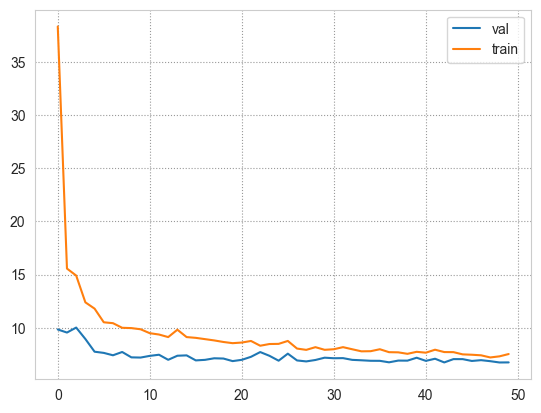

In [156]:
from keras.src.layers import Dropout
from keras.src.regularizers import regularizers
from keras.src.optimizers import Adam

# Создание модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1)) 

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['R2Score'])

# Обучение модели
epochs = 50
batch_size=16
history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test))

# выводим графики
sns.lineplot(y=history.history['val_loss'], x=np.arange(epochs), label='val')
sns.lineplot(y=history.history['loss'], x=np.arange(epochs), label='train')

In [157]:
df.describe()

,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,1.311306,1.020893,0.349374,23.567275,10.207342,5.136546,6.795844,9.954791
std,0.300431,0.248233,0.104976,13.891201,6.275275,3.104133,3.943392,3.220967
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [158]:
df['IMT'] = df['weight'] / (df['length'] )

In [159]:
df.columns

Index(['sex', 'length', 'diameter', 'height', 'weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'age', 'IMT'],
      dtype='object')

In [160]:
# разделяем данные
target = ['age']
# exclude_features = ['age']
exclude_features = ['age', 'length', 'diameter', 'height', 'weight', 'shucked_weight','viscera_weight', 'shell_weight']

X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# кодируем категориальные данные в зависимости от таргета
categorical_features = df.select_dtypes(include='object').columns.tolist()
columns_for_encoding = [feature for feature in categorical_features if feature not in exclude_features]

# X_train, X_test, _ = Encoder.oneHotEncoder(X_train, X_test, columns_for_encoding)
X_train, X_test, _ = Encoder.targetEncoder(X_train, X_test, y_train, columns_for_encoding)

# проводим нормализацию
X_train, X_test, _ = Normalizer().StandardScaler(X_train, X_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

# pca = PCA(n_components=0.95)
# X_train = pd.DataFrame(pca.fit_transform(X_train))
# X_test = pd.DataFrame(pca.transform(X_test))

In [161]:
X_train.columns

Index(['sex', 'IMT'], dtype='object')

In [162]:
# Применим метод опорных векторов
y_test, y_pred, _ = RegressionModel().SVR(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0, epsilon=0.01)
MetricCalculator.show_regression_metrics(y_test, y_pred)

R²: 0.298
MAE: 1.80
MAPE: 0%
RMSE: 3
MSE: 7
